# Predicting Telco Customer Churn on IBM Cloud Pak for Data (ICP4D)

We'll use this notebook to create a machine learning model to predict customer churn. In this notebook we will build the prediction model using the Scikit-Learn library.

This notebook walks you through these steps:

- Load and Visualize data set.
- Build a predictive model with Scikit-Learn
- Save the model in the ML repository

## 1.0 Install required packages

There are a couple of Python packages we will use in this notebook. 


In [1]:
import pandas as pd
import numpy as np
import json
import os

# Import the Project Library to read/write project assets
from project_lib import Project
#project = Project.access()

import warnings
warnings.filterwarnings("ignore")

In [5]:
# @hidden_cell
import pandas as pd
from project_lib import Project
project = Project.access()

DS16305912903780577_metadata = project.get_connection(name="DS16305912903780577")

import os, ibm_db, ibm_db_dbi as dbi, pandas as pd

DS16305912903780577_cert = os.path.join(os.path.expanduser('~'),'DS16305912903780577_ssl.cert')
f = open(DS16305912903780577_cert, "w")
f.write(DS16305912903780577_metadata['ssl_certificate'])
f.close()

DS16305912903780577_dsn = 'DATABASE={};HOSTNAME={};PORT={};PROTOCOL=TCPIP;UID={uid};PWD={pwd};SECURITY=SSL;SSLServerCertificate={cert}'.format(
    DS16305912903780577_metadata['database'],
    DS16305912903780577_metadata['host'],
    DS16305912903780577_metadata.get('port', 32051),
    uid=DS16305912903780577_metadata['username'],
    pwd=DS16305912903780577_metadata['password'],
    cert=DS16305912903780577_cert
)

DS16305912903780577_connection = dbi.connect(DS16305912903780577_dsn)
   
# NOTE:
#  A row limit has been applied to the query to enable sample previewing.
#  Adjust the display message and query as needed by editing the following lines:
from IPython.core.display import display, HTML
display(HTML("A row limit of 5000 has been applied to the query to enable sample previewing. If the data set is larger, only the first 5000 rows will be loaded."))
query = 'SELECT * FROM "ADMIN"."TELCO_CUSTOMER_CHURN" FETCH FIRST 5000 ROWS ONLY'

data_df_3 = pd.read_sql_query(query, con=DS16305912903780577_connection)
data_df_3.head()

# After use, close the database connection with the following code:
# DS16305912903780577_connection.close()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2.0 Load and Clean data

We'll load our data as a pandas data frame.

**<font color='red'><< FOLLOW THE INSTRUCTIONS BELOW TO LOAD THE DATASET >></font>**

* Highlight the cell below by clicking it.
* Click the `10/01` "Find data" icon in the upper right of the notebook.
* Choose the `Telco-Customer-Churn.csv`. Click `Insert to code` and choose `Insert Pandas DataFrame`.
* The code to bring the data into the notebook environment and create a Pandas DataFrame will be added to the cell below.
* Run the cell


We'll use the Pandas naming convention df for our DataFrame. Make sure that the cell below uses the name for the dataframe used above. For the locally uploaded file it should look like df_data_1 or df_data_2 or df_data_x.

**<font color='red'><< UPDATE THE VARIABLE ASSIGNMENT TO THE VARIABLE GENERATED ABOVE. >></font>**

In [9]:
# for virtualized data
# df = data_df_1

# for local upload
df = data_df_3

### 2.1 Drop CustomerID feature (column)

In [10]:
df = df.drop('customerID', axis=1)
df.head(5)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2.2 Examine the data types of the features

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5000 non-null   object 
 1   SeniorCitizen     5000 non-null   int64  
 2   Partner           5000 non-null   object 
 3   Dependents        5000 non-null   object 
 4   tenure            5000 non-null   int64  
 5   PhoneService      5000 non-null   object 
 6   MultipleLines     5000 non-null   object 
 7   InternetService   5000 non-null   object 
 8   OnlineSecurity    5000 non-null   object 
 9   OnlineBackup      5000 non-null   object 
 10  DeviceProtection  5000 non-null   object 
 11  TechSupport       5000 non-null   object 
 12  StreamingTV       5000 non-null   object 
 13  StreamingMovies   5000 non-null   object 
 14  Contract          5000 non-null   object 
 15  PaperlessBilling  5000 non-null   object 
 16  PaymentMethod     5000 non-null   object 


In [12]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,5000,5000.000000,5000,5000,5000.000000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000.000000,4992.000000,5000
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,2533,NaN,2594,3521,NaN,4538,2403,2191,2469,2177,2172,2477,1982,1954,2772,2951,1669,NaN,NaN,3687
mean,NaN,0.159600,NaN,NaN,32.257600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.781770,2275.162410,NaN
std,NaN,0.366271,NaN,NaN,24.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.141924,2268.920819,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN
25%,NaN,0.000000,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.487500,387.775000,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.400000,1397.475000,NaN
75%,NaN,0.000000,NaN,NaN,55.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.950000,3759.787500,NaN


We see that Tenure ranges from 0 (new customer) to 6 years, Monthly charges range from $18 to $118, etc

### 2.3 Convert TotalCharges and SeniorCitizen


In [13]:
df.TotalCharges = pd.to_numeric(df.TotalCharges,errors="coerce")
df.SeniorCitizen = df.SeniorCitizen.astype("object")

In [14]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,5000,5000.0,5000,5000,5000.000000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000.000000,4992.000000,5000
unique,2,2.0,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,2
top,Male,0.0,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,2533,4202.0,2594,3521,NaN,4538,2403,2191,2469,2177,2172,2477,1982,1954,2772,2951,1669,NaN,NaN,3687
mean,NaN,NaN,NaN,NaN,32.257600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.781770,2275.162410,NaN
std,NaN,NaN,NaN,NaN,24.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.141924,2268.920819,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN
25%,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.487500,387.775000,NaN
50%,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.400000,1397.475000,NaN
75%,NaN,NaN,NaN,NaN,55.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.950000,3759.787500,NaN


We now see statistics for the `TotalCharges` feature.



### 2.4 Any NaN values should be removed to create a more accurate model.

In [15]:
# Check if we have any NaN values and see which features have missing values that should be addressed
print(df.isnull().values.any())
df.isnull().sum()

True


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        8
Churn               0
dtype: int64

We should see that the `TotalCharges` column has missing values. There are various ways we can address this issue:

- Drop records with missing values 
- Fill in the missing value with one of the following strategies: Zero, Mean of the values for the column, Random value, etc).

In [16]:
# Handle missing values for nan_column (TotalCharges)
from sklearn.impute import SimpleImputer

# Find the column number for TotalCharges (starting at 0).
total_charges_idx = df.columns.get_loc("TotalCharges")
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

df.iloc[:, total_charges_idx] = imputer.fit_transform(df.iloc[:, total_charges_idx].values.reshape(-1, 1))
df.iloc[:, total_charges_idx] = pd.Series(df.iloc[:, total_charges_idx])

In [17]:
# Validate that we have addressed any NaN values
print(df.isnull().values.any())
df.isnull().sum()

False


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### 2.5 Categorize Features

We will categorize some of the columns / features based on wether they are categorical values or continuous (i.e numerical) values. We will use this in later sections to build visualizations.

In [12]:
df.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [18]:
columns_idx = np.s_[0:] # Slice of first row(header) with all columns.
first_record_idx = np.s_[0] # Index of first record

string_fields = [type(fld) is str for fld in df.iloc[first_record_idx, columns_idx]] # All string fields
all_features = [x for x in df.columns if x != 'Churn']
categorical_columns = list(np.array(df.columns)[columns_idx][string_fields])
categorical_features = [x for x in categorical_columns if x != 'Churn'] + ["SeniorCitizen"]
continuous_features = [x for x in all_features if x not in categorical_features]

print('All Features: ', all_features)
print('\nCategorical Features: ', categorical_features)
print('\nContinuous Features: ', continuous_features)
print('\nAll Categorical Columns: ', categorical_columns)

All Features:  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

Categorical Features:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

Continuous Features:  ['tenure', 'MonthlyCharges', 'TotalCharges']

All Categorical Columns:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


### 2.6 Visualize data

Data visualization can be used to find patterns, detect outliers, understand distribution and more. We can use graphs such as:

- Histograms, boxplots, etc: To find distribution / spread of our continuous variables.
- Bar charts: To show frequency in categorical values.


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(style="darkgrid")
sns.set_palette("hls", 3)

First, we get a high level view of the distribution of `Churn`. What percentage of customer in our dataset are churning vs not churning. 

Churn
No     3687
Yes    1313
dtype: int64


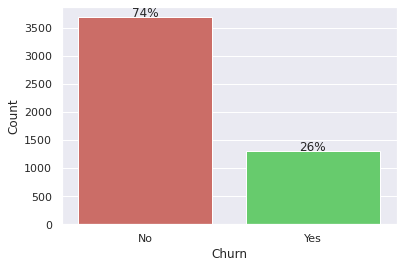

In [20]:
print(df.groupby(['Churn']).size())
churn_plot = sns.countplot(data=df, x='Churn', order=df.Churn.value_counts().index)
plt.ylabel('Count')
for p in churn_plot.patches:
    height = p.get_height()
    churn_plot.text(p.get_x()+p.get_width()/2., height + 1,'{0:.0%}'.format(height/float(len(df))),ha="center") 
plt.show()

Now try to plot the distribution of a continuos variable using the following code 

    plt.hist(df[variable_name])
    plt.title("Istogramma della variabile"+variable_name)
    plt.show()
    
Select a continuos variable from the list that we printed before

Let's try to do the same with a categorical variable 

    sns.countplot(x = variable_name, data=df).set_title(variable_name)
    plt.show()
 
Select a continuos variable from the list that we printed before

We can get use frequency counts charts to get an understanding of the categorical features relative to `Churn`  

- We can see that for the `gender` feature. We have relatively equal rates of churn by `gender`
- We can see that for the `InternetService` feature. We have higher churn for those that have "Fiber optic" service versus those with "DSL"


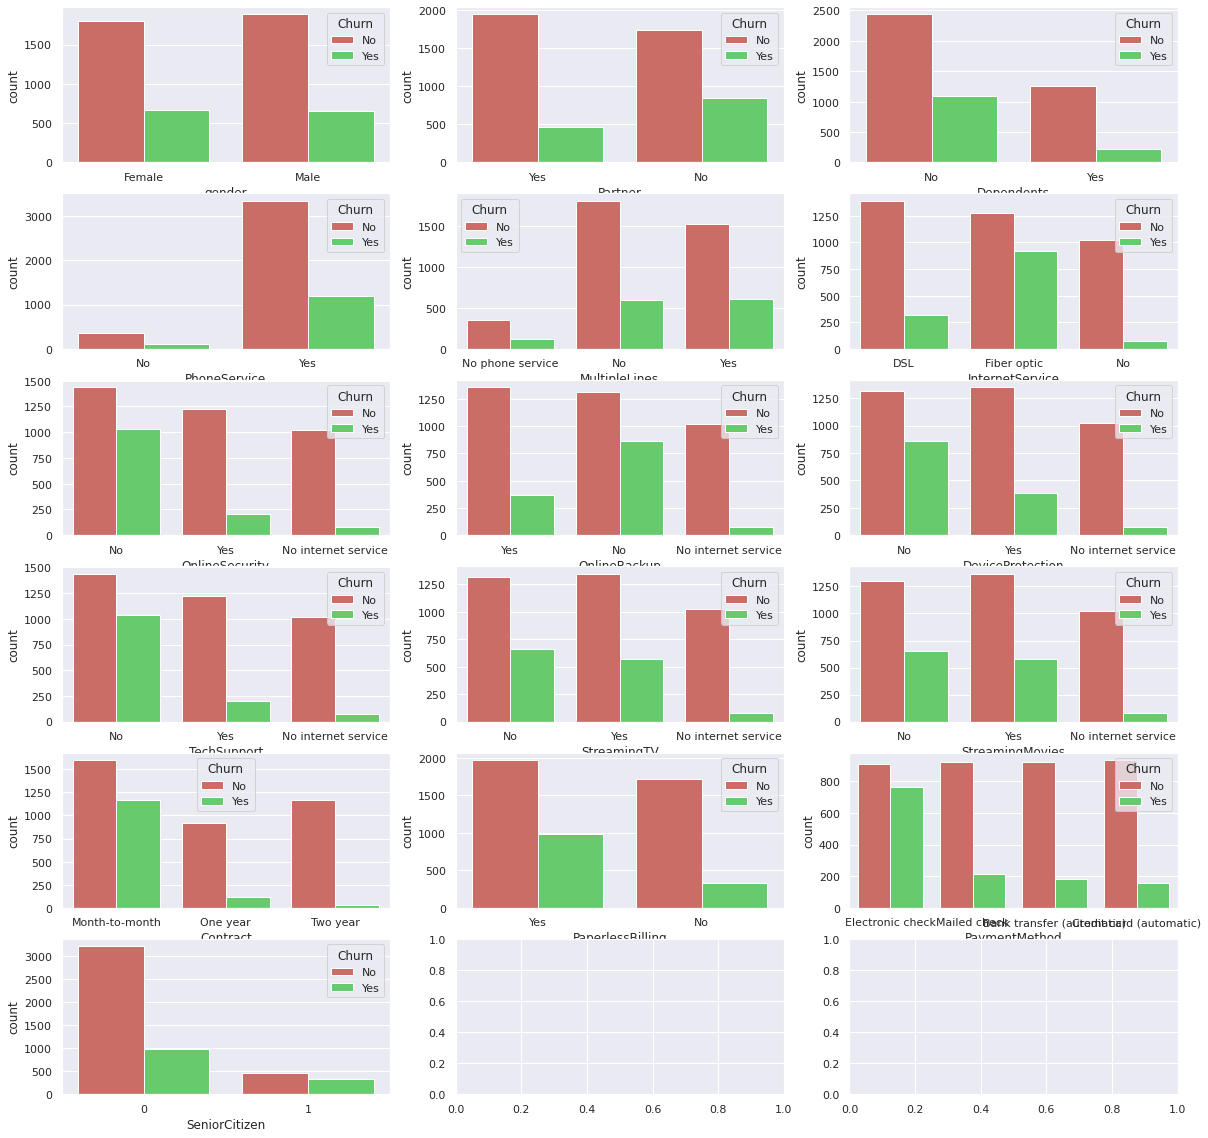

In [21]:
# Categorical feature count plots
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15),(ax16,ax17,ax18)) = plt.subplots(6, 3, figsize=(20, 20))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15,ax16]

for i in range(len(categorical_features)):
    sns.countplot(x = categorical_features[i], hue="Churn", data=df, ax=ax[i])

We can get use histrogram charts to get an understanding of the distribution of our continuous / numerical features relative to Churn.

- We can see that for the `MonthlyCharges` feature, customers that churn tend to pay higher monthly fees than those that stay.
- We can see that for the `tenure` feature, customers that churn tend to be relatively new customers.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0731844190>,
      dtype=object)

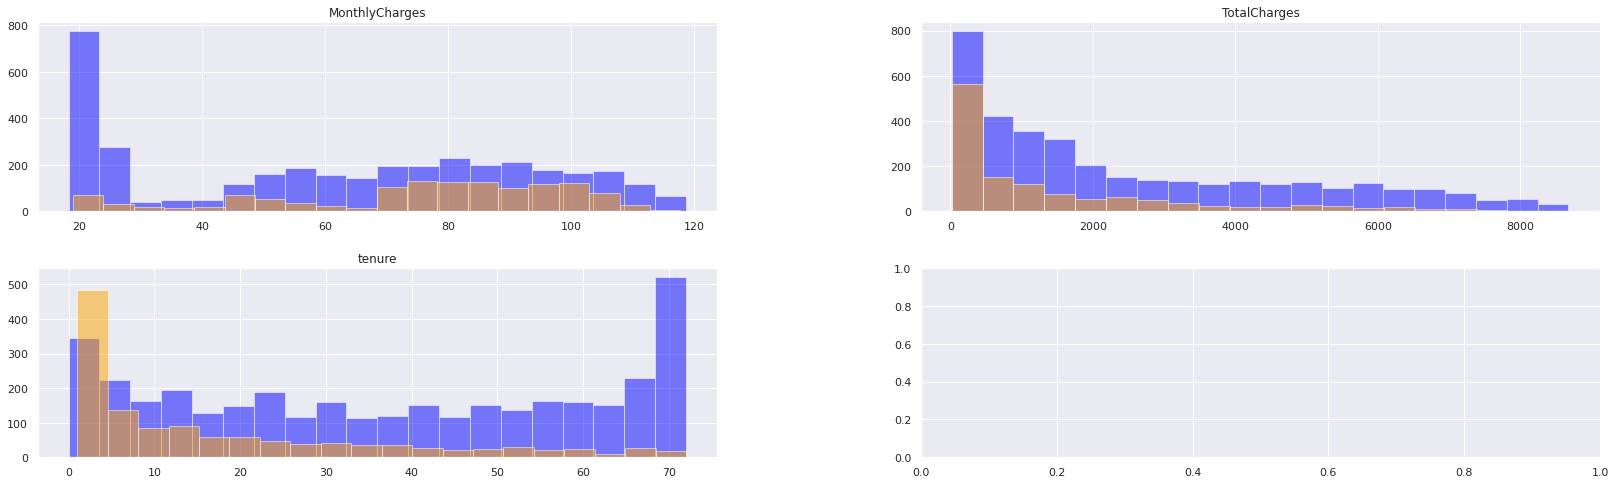

In [22]:
# Continuous feature histograms.
fig, ax = plt.subplots(2, 2, figsize=(28, 8))
df[df.Churn == 'No'][continuous_features].hist(bins=20, color="blue", alpha=0.5, ax=ax.flatten()[:3])
df[df.Churn == 'Yes'][continuous_features].hist(bins=20, color="orange", alpha=0.5, ax=ax.flatten()[:3])

# Or use displots
#sns.set_palette("hls", 3)
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))
#ax = [ax1, ax2, ax3, ax4]
#for i in range(len(continuous_features)):
#    sns.distplot(df[continuous_features[i]], bins=20, hist=True, ax=ax[i])

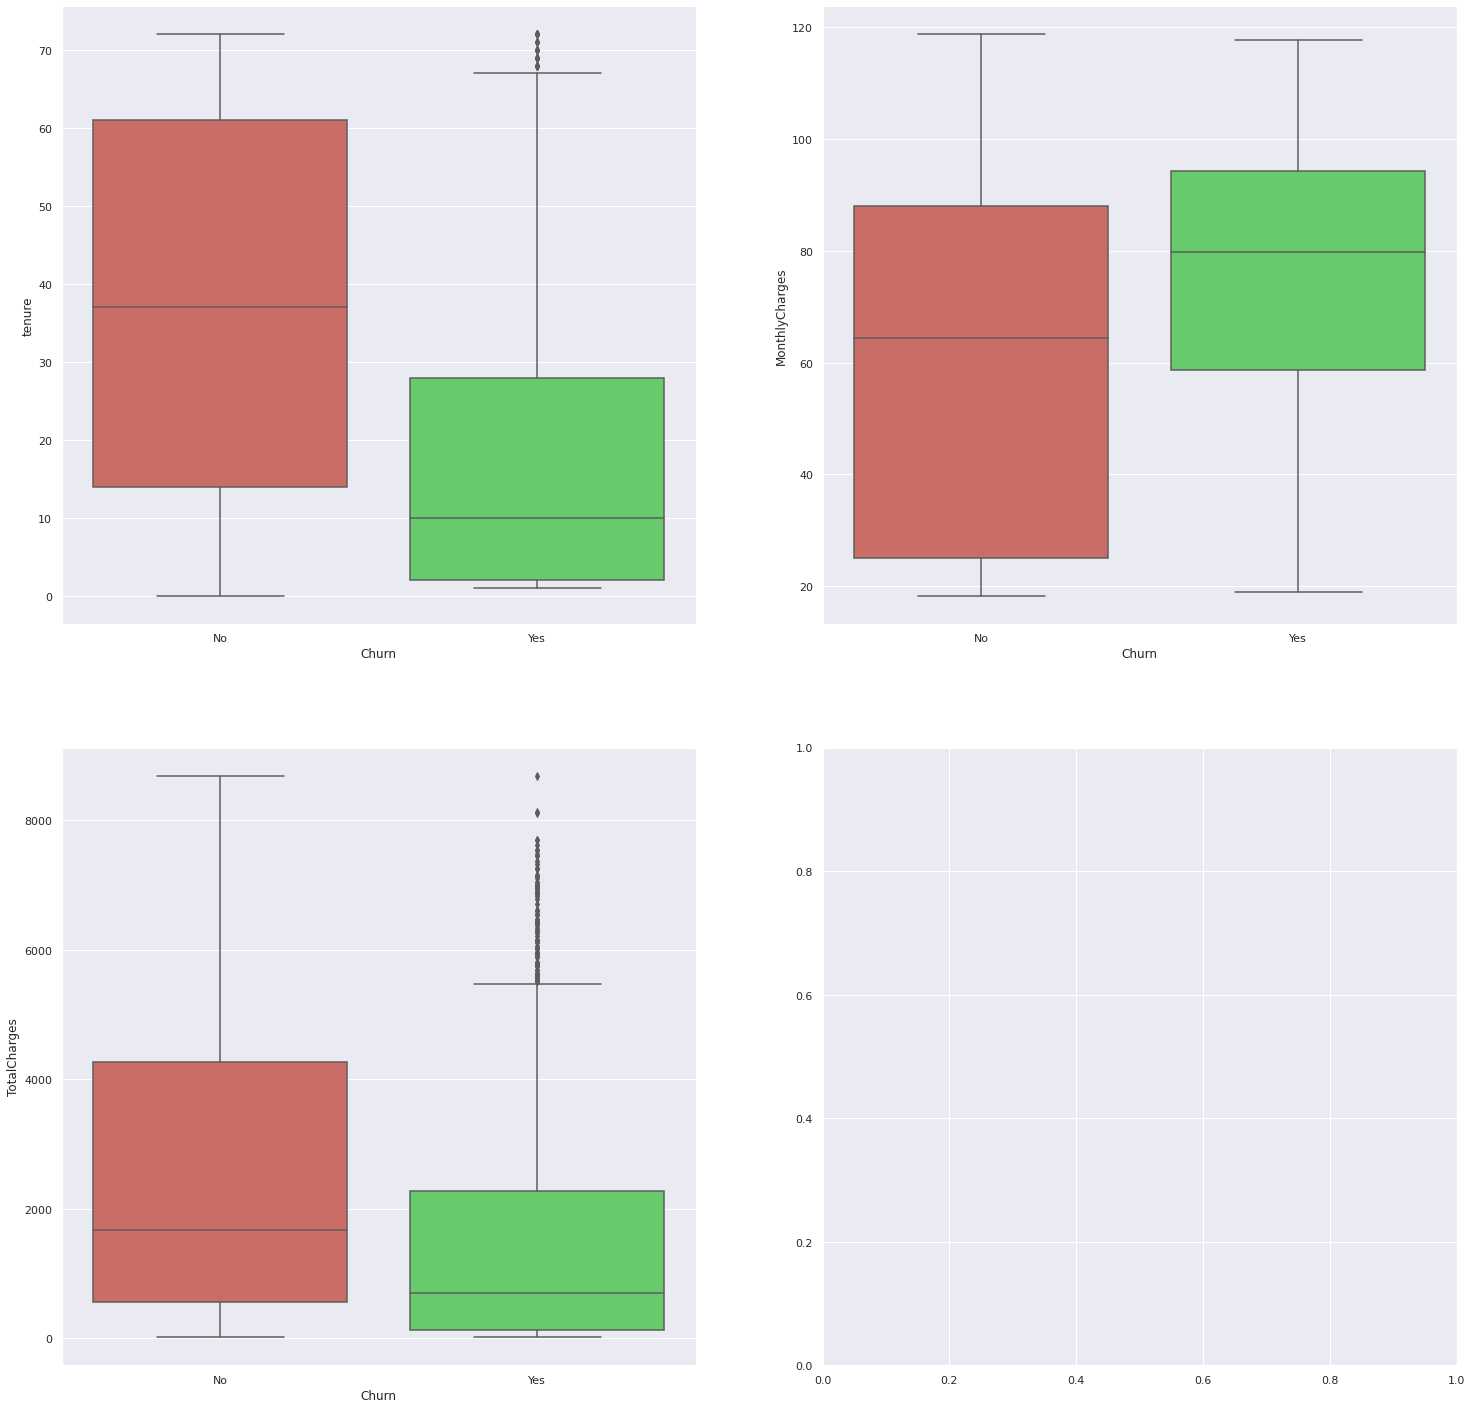

In [23]:
# Plot boxplots of numerical columns. More variation in the boxplot implies higher significance. 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3]

for i in range(len(continuous_features)):
    sns.boxplot(x = 'Churn', y = continuous_features[i], data=df, ax=ax[i])

## 3.0 Create a model

Now we can create our machine learning model. You could use the insights / intuition gained from the data visualization steps above to what kind of model to create or which features to use. We will create a simple classification model.

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### 3.1 Split the data into training and test sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df[categorical_features+continuous_features],df["Churn"], test_size=0.20, random_state=0)

print("Number of records for training: " + str(X_train.shape[0]))
print("Number of records for evaluation: " + str(X_test.shape[0]))

Number of records for training: 4000
Number of records for evaluation: 1000


### 3.3 Use OneHotEncoder to encode a string column of labels 

We are using the Pipeline package to build the development steps as pipeline. 
We are using OneHotEncoder to handle categorical / string features from the dataset.

We then use ColumnTransformer to apply this transformation only to catecorigal features.

In [26]:
model_preprocessor = ColumnTransformer(
    [("onehot_categorical", OneHotEncoder(),categorical_features)],
    remainder='passthrough'
)


### 3.4 Create the model

We are using LogisticRegression

In [28]:
model = LogisticRegression()

### 3.5 Create a pipeline, and fit it to the data

Assemble all the stages into a pipeline. 

In [29]:
pipe_model = Pipeline([
    ("preprocessor", model_preprocessor),
    ("regressor", model)
])


In [30]:
#Prediction
pipe_model.fit(X_train, y_train)

y_hat = pipe_model.predict_proba(X_test)

### 3.6 Evaluation of the model

In [31]:
area_under_curve = roc_auc_score(y_true=y_test,y_score=y_hat[:,1])
print("areaUnderROC = %g" % area_under_curve)

areaUnderROC = 0.842758


## 4.0 Deploy the model in Watson Machine Learning

Steps to follow:

    Access Watson Machine Learning
    Setting of the deployment space
    Storing the model into WML 
    Deploy it

In [ ]:
from ibm_watson_machine_learning import APIClient

**<font color='red'><< REPLACE api_key and location BELOW with your api key and your location.</font>**

In [ ]:
api_key = "PLACE YOUR API_KEY HERE"
location = 'eu-de'

In [ ]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

In [ ]:
client = APIClient(wml_credentials)

**<font color='red'><< REPLACE space_id BELOW with the id for your space. For e.g.<br/>client.set.default_space("6b39c537-f707-4078-9dc7-ce70b70ab22f") >></font>**

In [ ]:
space_id = 'PLACE YOUR SPACE_ID HERE'
client.set.default_space(space_id)

#### Save the Model

In [ ]:
# Store our model
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")

metadata = {
            client.repository.ModelMetaNames.NAME: 'Scikit model',
            client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = client.repository.store_model(
    model=pipe_model,
    meta_props=metadata,
    training_data=X_train,
    training_target=y_train)

published_model_uid = client.repository.get_model_uid(published_model)

print(json.dumps(published_model, indent=3))

In [ ]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of scikit model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_uid, meta_props=metadata)


In [ ]:
# Use this cell to do any cleanup of previously created models and deployments
client.repository.list_models()
client.deployments.list()

# client.repository.delete('GUID of stored model')
# client.deployments.delete('GUID of deployed model')


## Congratulations, you have created a model based on customer churn data, and deployed it to Watson Machine Learning!

## 5. OPTIONAL

Let's try to understand the effect of the variable XYZ on the target. In order to do that, apply the appropriate statistical - non parametri - test.

In the modelling phase, usually, several techniques are compared. Choose a different supervised technique (i.e. SVM, random forest, lightGBM, xgboost etc.) and apply gridsearch to find the optimal combination of the hyperparameters that maximize the AUC